Pada kesempatan ini, akan dibangun model klasifikasi untuk mengelompokkan data $\mathbb{R}^2$ (ruang 2D) dengan 2 label sederhana. Hasil akan membagi $\mathbb{R}^2$ menjadi 2 daerah yang saling lepas, berdasarkan data yang digunakan.

Model akan menggunakan dua pendekatan, yakni regresi logistik dan <i>artificial neural network</i> dengan satu <i>hidden layer</i> (disebut juga <i>shallow neural network</i>).

### 1. Persiapan


##### 1.1. Library dan Dataset

Import beberapa library yang akan digunakan:

In [31]:
# Import library
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets as sds

Dataset yang digunakan berasal dari `sklearn.datasets`. Data berisi kumpulan titik-titik pada ruang 2 dimensi, dengan label 0 atau 1. Terdapat beberapa bentuk dataset yang dapat digunakan.

In [32]:
# Datasets
class PlanarDataset(object):
    # Inisiasi ukuran dataset
    def __init__(self, points_per_class):
        self.N = points_per_class

    # Buat dataset yang diinginkan
    def load_dataset(self, shape):
        X, Y = getattr(self, "get_"+shape)()
        X, Y = X.T, np.expand_dims(Y, 0)
        return X, Y
        
    # Dataset berbentuk lingkaran
    def get_circles(self):
        return sds.make_circles(n_samples=self.N, factor=.5, noise=.3)

    # Dataset berbentuk bulan sabit
    def get_moons(self):      
        return sds.make_moons(n_samples=self.N, noise=.2)

    # Beberapa kluster titik
    def get_blobs(self):
        X, Y = sds.make_blobs(n_samples=self.N, random_state=5, n_features=2, centers=6)
        Y = Y%2
        return X, Y

    # Dataset dengan lingkaran dalam (pusat (0,0)) + daerah diluar lingkaran
    def get_quantiles(self):
        return sds.make_gaussian_quantiles(mean=None, cov=0.5, 
                                           n_samples=self.N, n_features=2, 
                                           n_classes=2, shuffle=True, 
                                           random_state=1)      

    # Acak
    def get_random(self):
        return np.random.rand(self.N, 2), np.random.randint(2, size=self.N)

    # Bisa dibagi dengan 1 garis lurus, namun dengan keacakan
    def get_plain(self):
        X, Y = sds.make_classification(n_samples=200, n_features=2, n_redundant=0, 
                                       n_informative=2, random_state=1, 
                                       n_clusters_per_class=1)
        rng = np.random.RandomState(2)
        X += 2 * rng.uniform(size=X.shape)
        return X, Y

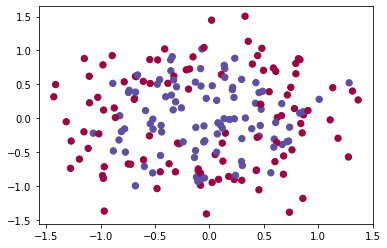

In [33]:
# Membuat dataset baru dengan ukuran 200 titik
loader = PlanarDataset(200)

# Contoh salah satu dataset
X, Y = loader.load_dataset('circles')
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

##### 1.2. Fungsi pendukung lain

Selanjutnya, disiapkan fungsi untuk pelabelan suatu kumpulan titik pada suatu model.

In [34]:
# Fungsi untuk melabelkan
def plot_decision_boundary(model, X, y):
    # Domain x, y
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    # Lebar partisi pewarnaan
    h = 0.01
    # Meshgrid untuk pewarnaan label daerah
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Mencari label menggunakan model neural network
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot hasil
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)



Fungsi sigmoid

In [35]:
def sigmoid(x):
    s = 1/(1 + np.exp(-x))
    return s

##### 1.3. Membangun Regresi Logistik

Menggunakan regresi logistik, digunakan perhitungan <i>cost</i> $C$ saat melakukan propagasi maju dan turunan <i>cost</i> $\frac{dC}{dx}$ yakni:
$$C=-\frac{1}{N}\sum_{i=1}^N [y_i \log(a_i)+(1-y_i)\log(1-a_i)]$$

Fungsi <i>cost</i> ini disebut juga sebagai <i>binary crossentropy</i>.

Selain itu, aktivasi akan menggunakan fungsi sigmoid.

In [36]:
# Membangun regresi logistik
class LogisticRegressor(object):
    # Inisiasi
    def __init__(self, cost_log = True):
        self.W = None
        self.b = None
        self.print_cost = cost_log

    # Inisiasi nilai awal acak
    def initialize_random(self, num_features):
        self.w = np.random.rand(num_features, 1)
        self.b = np.random.rand(1)
        self.costs = []

    # Inisiasi parameter dan data model 
    def setup(self, X, Y, num_iterations = 2000, learning_rate = 0.5):
        self.initialize_random(X.shape[0])
        self.X = X.T
        self.Y = Y.reshape((Y.shape[1], Y.shape[0]))
        self.num_iterations = num_iterations
        self.learning_rate = learning_rate

    # Propagasi (1x)
    def propagate(self):
        N = self.X.shape[0]

        # Propagasi maju
        Z = np.dot(self.X, self.w) + self.b
        # Fungsi aktivasi
        A = sigmoid(Z)
        # Menghitung cost
        logprob = np.multiply(self.Y, np.log(A)) + np.multiply(1 - self.Y, np.log(1 - A))
        cost = - np.sum(logprob) / N
        self.costs.append(cost)

        # Propagasi mundur
        e = self.Y - A
        dz = -e/N
        # Delta w dan Delta b untuk memperbaiki nilai w dan b
        dw = np.dot(self.X.T, dz)
        db = np.sum(dz)
        
        return dw, db

    # Perulangan propagasi untuk pengoptimalan
    def optimize(self):
        # Propagasi dilakukan sebanyak num_iterations
        for i in range(self.num_iterations):
            # Memanggil fungsi 'propagate' untuk mencari nilai Delta w dan Delta b
            dw, db = self.propagate()

            # Update nilai Delta w dan Delta b baru
            self.w -= self.learning_rate * dw
            self.b -= self.learning_rate * db
            
            # Menampilkan cost tiap 100x iterasi
            if (i % 100 == 0) and (self.print_cost):
                  print ("Cost after iteration %i: %f" %(i, self.costs[i]))

    # Melakukan prediksi dengan model yang digunakan
    def predict(self, X_pred):
        # Menghitung nilai prediksi
        forward = np.dot(X_pred, self.w) + self.b

        # Output memiliki nilai 0 atau 1
        predictions = forward > 0.5 
        return predictions

    # Mencari akurasi model
    def get_accuracy(self):
        # Melakukan prediksi
        Y_pred = self.predict(self.X)
        # Menghitung banyak titik dengan label benar
        correct = np.dot(self.Y.T, Y_pred) + np.dot(1-self.Y.T, 1-Y_pred)
        # Akurasi model
        accuracy = float(correct)/float(self.Y.size)*100 
        print("train accuracy: {} %".format(accuracy))

    # Melakukan train / optimisasi model
    def train(self):
        self.optimize()


Sebagai percobaan, akan digunakan model di atas untuk data `plain`

In [37]:
X, Y = loader.load_dataset('plain')

model = LogisticRegressor()
model.setup(X, Y, num_iterations = 2000, learning_rate = 0.05)
model.train()
model.get_accuracy()

Cost after iteration 0: 1.172828
Cost after iteration 100: 0.393322
Cost after iteration 200: 0.368352
Cost after iteration 300: 0.360286
Cost after iteration 400: 0.356828
Cost after iteration 500: 0.355116
Cost after iteration 600: 0.354184
Cost after iteration 700: 0.353640
Cost after iteration 800: 0.353302
Cost after iteration 900: 0.353082
Cost after iteration 1000: 0.352931
Cost after iteration 1100: 0.352824
Cost after iteration 1200: 0.352744
Cost after iteration 1300: 0.352684
Cost after iteration 1400: 0.352638
Cost after iteration 1500: 0.352602
Cost after iteration 1600: 0.352572
Cost after iteration 1700: 0.352549
Cost after iteration 1800: 0.352530
Cost after iteration 1900: 0.352514
train accuracy: 85.5 %


Terlihat bahwa akurasi model mencapai 85.5%

##### 1.4. Shallow Neural Network

Inisiasi parameter bobot $w$ (menggunakan nilai acak), parameter bias $b$ (menggunakan nilai nol).

In [38]:
def initialize_parameters(n_x, n_h, n_y):    
    # Inisialisasi w secara acak dan b dengan 0
    w1 = np.random.randn(n_h , n_x)
    b1 = np.zeros((n_h, 1))
    w2 = np.random.randn(n_y , n_h)
    b2 = np.zeros((n_y, 1))
    
    return w1, w2, b1, b2

Selanjutnya fungsi propagasi maju dan mundur. Pada model <i>neural network</i>, ingin diminimalisasi <i>cost</i> atau galat:
$$ Z = X \cdot W + b $$
dengan 
$$ C = \frac{1}{N} [(Y - Z)' \cdot (Y - Z)] $$

Untuk propagasi mundur, dihitung gradien dari <i>cost</i> terhadap parameter-parameter yang digunakan:
$$ \frac{dC}{dZ} = -\frac{1}{N} 2(Y - Z) $$

$$ \frac{\partial C}{\partial w} = \frac{\partial Z}{\partial w} \frac{dC}{dZ} = -\frac{1}{N}(X' \cdot 2(Y-Z)) $$

$$ \frac{\partial C}{\partial b} = \frac{\partial Z}{\partial b} \frac{dC}{dZ} = -\frac{1}{N} \sum_{m=1}^{N} 2(y_m - z_m)$$

dengan $N$ banyak data. Pembagian dengan $N$ digunakan untuk menghitung rata-rata.

Sehingga propagasi maju, dengan fungsi aktivasi tanh dan sigmoid:

In [39]:
def forward_propagation(X, w1, w2, b1, b2):
    # Input -> Hidden layer
    Z1 = np.dot(w1, X) + b1
    A1 = np.tanh(Z1) 
    # Hidden layer -> output
    Z2 = np.dot(w2, A1) + b2
    A2 = sigmoid(Z2)
        
    return A1, A2

Serta propagasi mundur:

In [40]:
def backward_propagation(A1, A2, w2, X, Y):
    m = X.shape[1]

    # Output -> Hidden Layer
    dZ2 = A2 - Y
    dw2 = np.dot(dZ2, A1.T)/m
    db2 = np.sum(dZ2, axis=1, keepdims=True)/m
    # Hidden Layer -> Input
    dZ1 = np.dot(w2.T, dZ2) * (1. - np.power(A1, 2))
    dw1 = np.dot(dZ1, X.T)/m
    db1 = np.sum(dZ1, axis=1, keepdims=True)/m
    
    return dw1, dw2, db1, db2

Update parameter menggunakan persamaan:
$$ w = w - \alpha \frac{\partial C}{\partial w} $$
$$ b = b - \alpha \frac{\partial C}{\partial b} $$
dengan $\alpha$ merupakan <i>learning rate</i>.

In [41]:
# Update parameter
def update_parameters(parameters, grads, learning_rate = 1.2):
    w1, w2, b1, b2 = parameters
    dw1, dw2, db1, db2 = grads

    w1 -= learning_rate * dw1
    b1 -= learning_rate * db1
    w2 -= learning_rate * dw2
    b2 -= learning_rate * db2
        
    return w1, w2, b1, b2

Fungsi untuk menghitung <i>cost</i>:

In [42]:
# Fungsi untuk menghitung cost
def compute_cost(A2, Y):
    m = Y.shape[1]

    logprobs = np.multiply(np.log(A2), Y) + np.multiply(np.log(1-A2), 1-Y)
    cost =  - np.sum(logprobs)/m
    
    return float(np.squeeze(cost))

Terakhir, didefinisikan fungsi untuk melakukan prediksi dan menghitung akurasi model.

In [43]:
# Fungsi untuk melakukan prediksi
def predict(parameters, X):    
    _, A2 = forward_propagation(X, *parameters)
    predictions = A2 > 0.5
    
    return predictions

In [44]:
# Fungsi untuk menghitung akurasi model
def get_accuracy(parameters, X, Y):
    predictions = predict(parameters, X)
    correctly_predicted = np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T)
    accuracy = float(correctly_predicted)/float(Y.size)*100  
    print("train accuracy: {} %".format(accuracy))

Sehingga, model <i>neural network</i> keseluruhan:

In [45]:
def nn_model(X, Y, n_h, num_iterations = 10000, learning_rate = 1.2, print_cost=False):    
    n_x = X.shape[0]    # Banyak input
    n_y = Y.shape[0]    # Banyak output
    parameters = initialize_parameters(n_x, n_h, n_y)

    # Proses iterasi optimisasi
    for i in range(0, num_iterations):
        A1, A2 = forward_propagation(X, *parameters)
        cost = compute_cost(A2, Y)
        grads = backward_propagation(A1, A2, parameters[1], X, Y)
        parameters = update_parameters(parameters, grads, learning_rate)
        if print_cost and i % (num_iterations // 10) == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

### 2. Demostrasi model neural network dan regresi logistik + Analisis banyak neuron

##### 2.1 - Plain

Berikut adalah hasil training menggunakan data 'plain'

Accuracy for 1 hidden units: 85.5 %
Accuracy for 2 hidden units: 86.5 %
Accuracy for 3 hidden units: 88.0 %
Accuracy for 4 hidden units: 85.5 %
Accuracy for 5 hidden units: 89.0 %
Accuracy for 6 hidden units: 88.5 %
Accuracy for 7 hidden units: 88.0 %
Accuracy for 8 hidden units: 88.0 %
Accuracy for 9 hidden units: 88.0 %
Accuracy for 10 hidden units: 92.0 %
Accuracy for 11 hidden units: 89.0 %
Accuracy for 12 hidden units: 91.0 %
Accuracy for 13 hidden units: 90.5 %
Accuracy for 14 hidden units: 89.5 %
Accuracy for 15 hidden units: 88.5 %


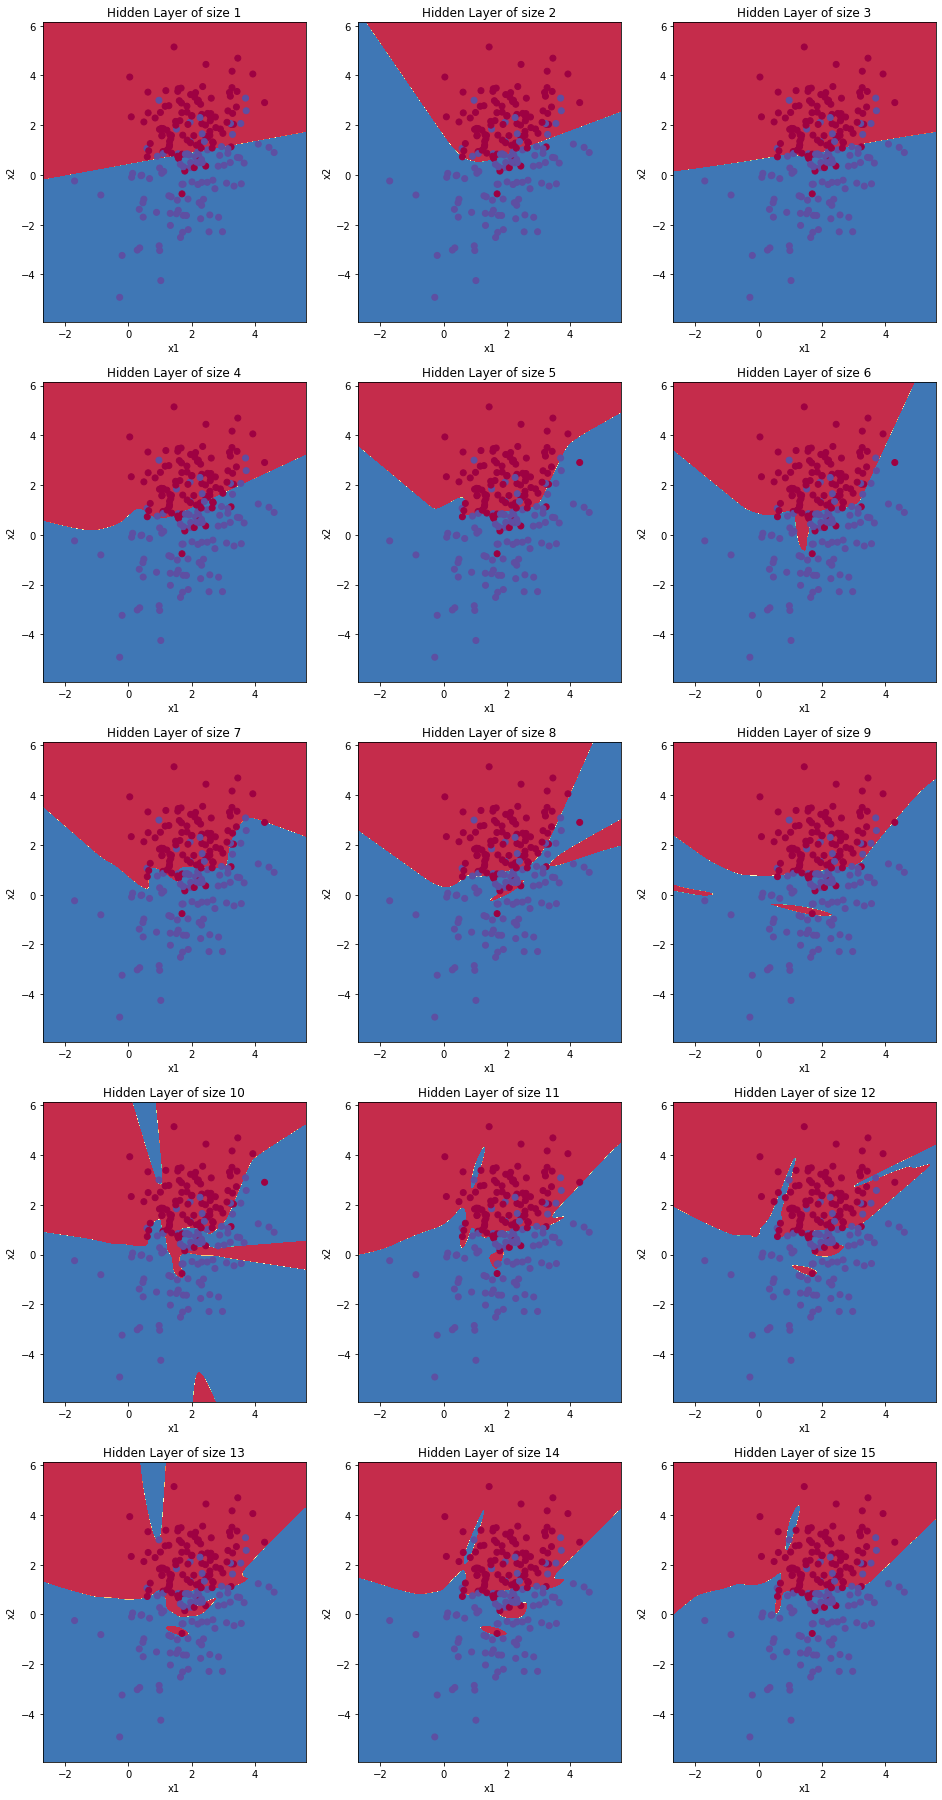

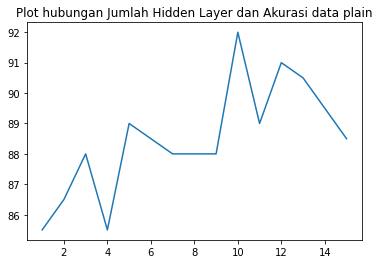

In [46]:
# Bentuk yang diinginkan
shape = "plain"
# Ambil dataset
X, Y = loader.load_dataset(shape)
# Membuat plot baru
plt.figure(figsize=(16, 32))
# Membuat lis banyak neuron pada hidden layer yang akan digunakan [1, 2, ..., 15]
hidden_layer_sizes = np.arange(1, 16, 1)
# Akurasi dari tiap hidden layer
accuracy = []

# Looping tiap banyak neuron
for i, n_h in enumerate(hidden_layer_sizes):
    # Plot
    plt.subplot(5, 3, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    # Model
    parameters = nn_model(X, Y, n_h, num_iterations = 10000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    acc = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, acc))
    accuracy.append(acc)
plt.show()

# Plot grafik banyak hidden layer serta akurasi-nya
plt.title('Plot hubungan Jumlah Hidden Layer dan Akurasi data ' +shape)
plt.plot(hidden_layer_sizes, accuracy)
plt.show()

Perhatikan bahwa dengan menggunakan 1 neuron pada hidden layer, sudah didapat akurasi yang besar, yakni $86.5 \%$. Lebih lanjut, dapat dilihat dari plot bahwa 1 neuron sudah cukup baik membagi daerah pada dataset 'plain'. Selain itu, penambahan banyak neuron tidak memberikan efek yang signifikan, karena akurasi hanya berada pada range $86-91 \%$ untuk perbedaan banyak neuron yang signifikan (1 neuron dengan 15 neuron).

Sehingga dapat disimpulkan bahwa 1 neuron sudah cukup untuk membuat *desicion boundary* yang baik.

#### 2.2 - Circles



Berikut adalah hasil training menggunakan data 'circles'

Accuracy for 1 hidden units: 59.5 %
Accuracy for 2 hidden units: 69.0 %
Accuracy for 3 hidden units: 78.5 %
Accuracy for 4 hidden units: 79.5 %
Accuracy for 5 hidden units: 79.0 %
Accuracy for 6 hidden units: 81.0 %
Accuracy for 7 hidden units: 81.5 %
Accuracy for 8 hidden units: 81.5 %
Accuracy for 9 hidden units: 81.0 %
Accuracy for 10 hidden units: 83.0 %
Accuracy for 11 hidden units: 82.5 %
Accuracy for 12 hidden units: 83.5 %
Accuracy for 13 hidden units: 84.5 %
Accuracy for 14 hidden units: 84.5 %
Accuracy for 15 hidden units: 85.5 %


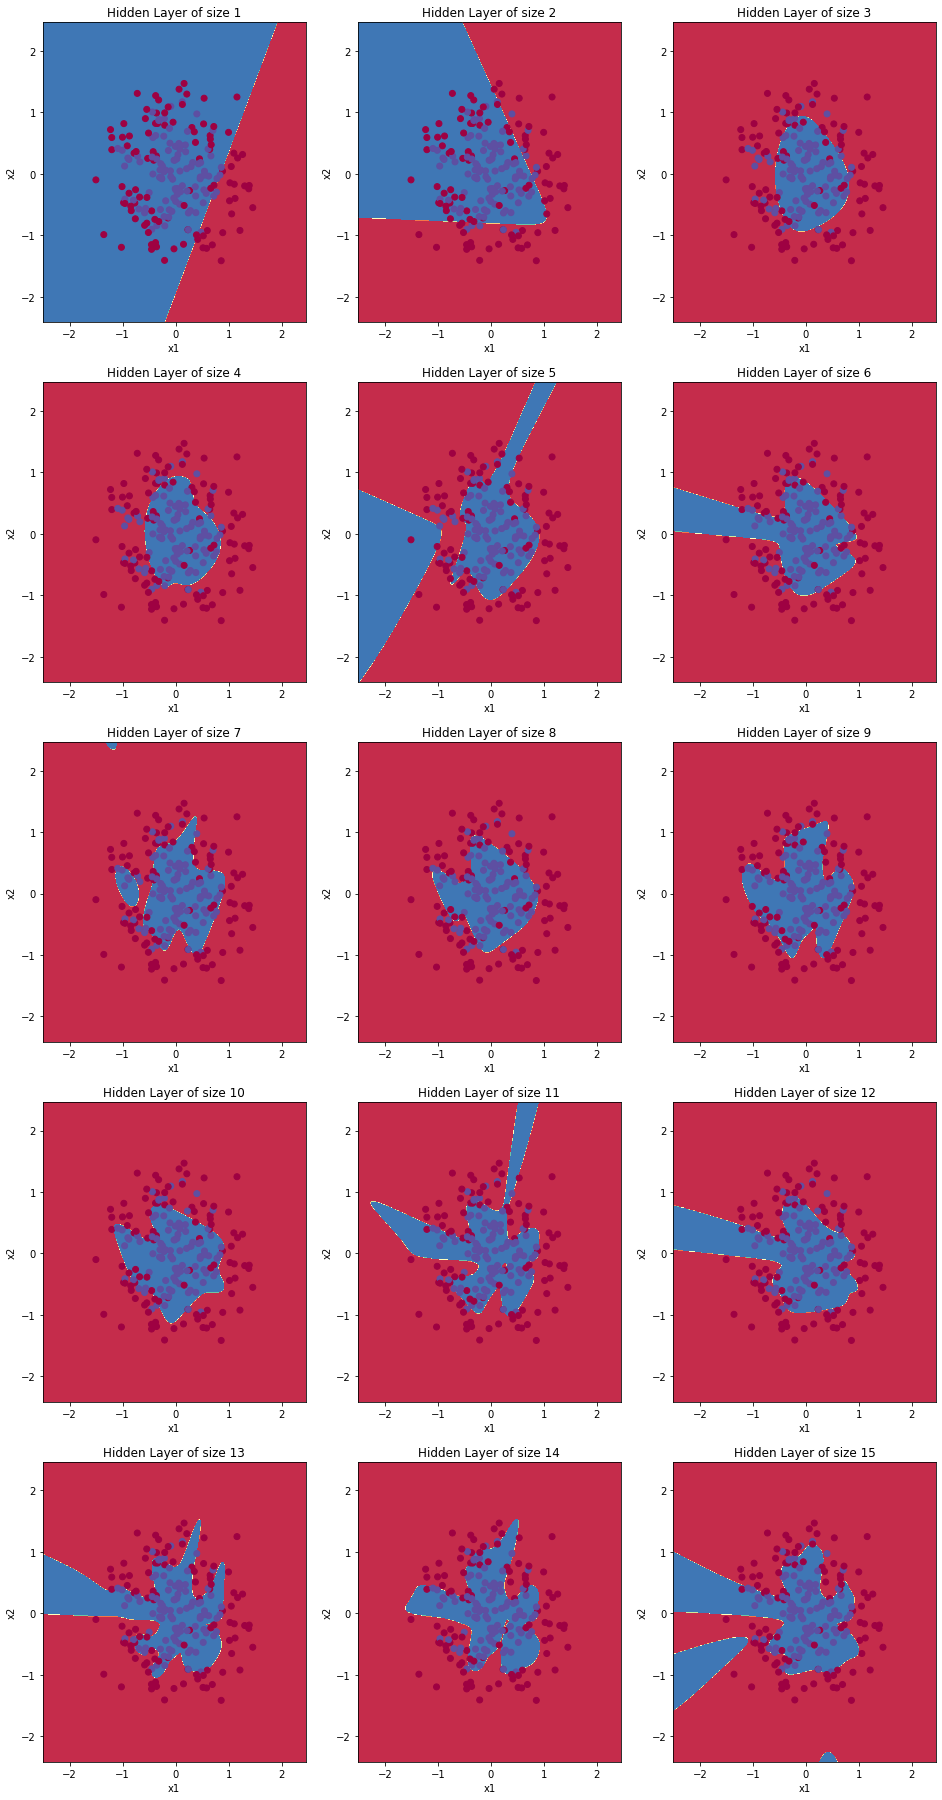

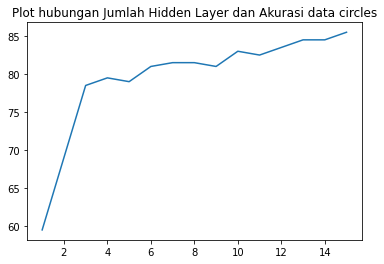

In [47]:
# Bentuk yang diinginkan
shape = "circles"
# Ambil dataset
X, Y = loader.load_dataset(shape)
# Membuat plot baru
plt.figure(figsize=(16, 32))
# Membuat list banyak neuron pada hidden layer yang akan digunakan [1, 2, ..., 15]
hidden_layer_sizes = np.arange(1, 16, 1)
# Akurasi dari tiap hidden layer
accuracy = []
# Looping tiap banyak neuron
for i, n_h in enumerate(hidden_layer_sizes):
    # Plot
    plt.subplot(5, 3, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    # Model
    parameters = nn_model(X, Y, n_h, num_iterations = 10000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    acc = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, acc))
    accuracy.append(acc)
plt.show()

# Plot grafik banyak hidden layer serta akurasi-nya
plt.title('Plot hubungan Jumlah Hidden Layer dan Akurasi data ' +shape)
plt.plot(hidden_layer_sizes, accuracy)
plt.show()

Perhatikan bahwa secara visual, daerah dapat dibagi menjadi 2 daerah, yakni lingkaran di dalam serta sisanya. Untuk membentuk lingkaran tersebut, kita dapat membentuk bentuk terdekatnya yakni segitiga menggunakan 3 neuron. Sehingga, minimal dibutuhkan 3 neuron untuk dapat membagi daerah tersebut dengan baik.

Hal ini dapat diverifikasi dari plot akurasi. Terlihat ketika banyak neuron $1-3$, peningkatannya sangat signifikan. Sedangkan banyak neuron $\geq 3$ kenaikan akurasinya jauh lebih lambat.

Sehingga, kita cukup membutuhkan 3 buah neuron untuk membangun $decision boundary$ untuk data pada kasus 'circle' ini.

#### 2.3 - Moons

Berikut adalah hasil training menggunakan data 'moons'

Accuracy for 1 hidden units: 85.5 %
Accuracy for 2 hidden units: 86.5 %
Accuracy for 3 hidden units: 94.5 %
Accuracy for 4 hidden units: 93.5 %
Accuracy for 5 hidden units: 94.5 %
Accuracy for 6 hidden units: 95.0 %
Accuracy for 7 hidden units: 95.0 %
Accuracy for 8 hidden units: 95.0 %
Accuracy for 9 hidden units: 94.5 %
Accuracy for 10 hidden units: 95.0 %
Accuracy for 11 hidden units: 95.0 %
Accuracy for 12 hidden units: 94.5 %
Accuracy for 13 hidden units: 94.5 %
Accuracy for 14 hidden units: 94.5 %
Accuracy for 15 hidden units: 94.5 %


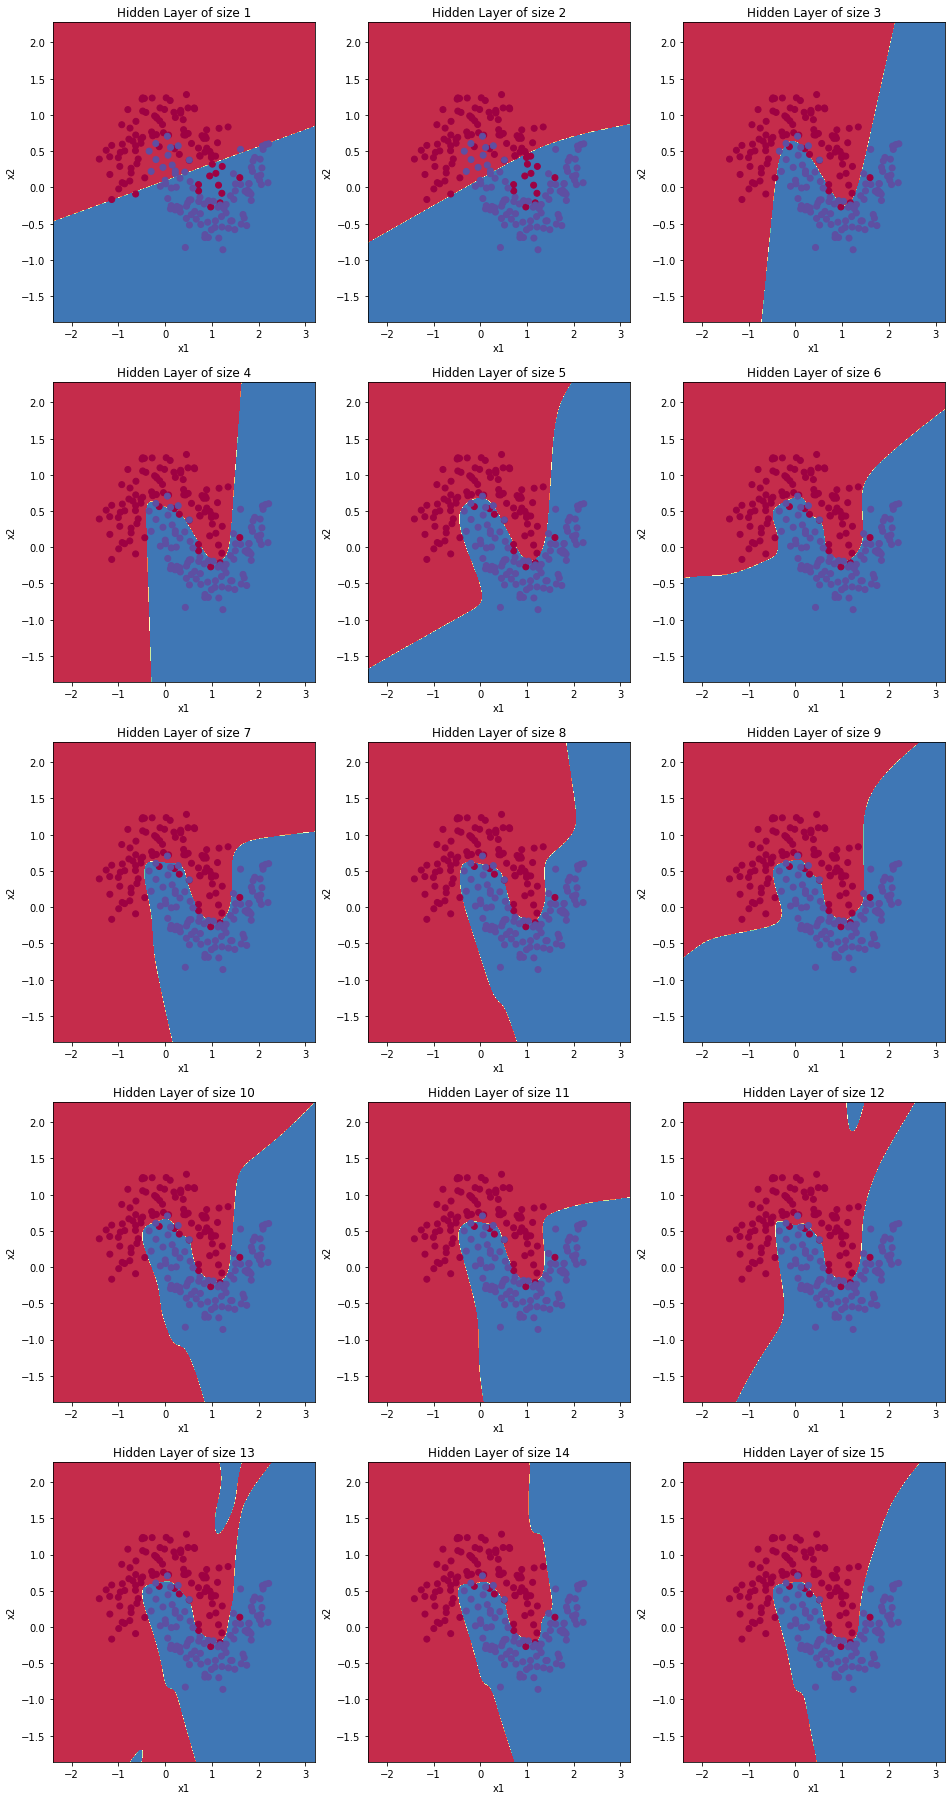

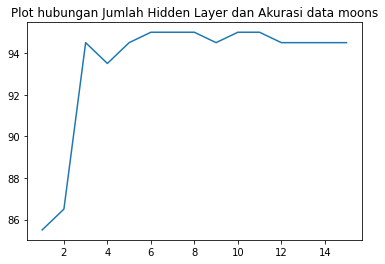

In [48]:
# Bentuk yang diinginkan
shape = "moons"
# Ambil dataset
X, Y = loader.load_dataset(shape)
# Membuat plot baru
plt.figure(figsize=(16, 32))
# Membuat list banyak neuron pada hidden layer yang akan digunakan [1, 2, ..., 15]
hidden_layer_sizes = np.arange(1, 16, 1)
# Akurasi dari tiap hidden layer
accuracy = []
# Looping tiap banyak neuron
for i, n_h in enumerate(hidden_layer_sizes):
    # Plot
    plt.subplot(5, 3, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    # Model
    parameters = nn_model(X, Y, n_h, num_iterations = 10000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    acc = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, acc))
    accuracy.append(acc)
plt.show()

# Plot grafik banyak hidden layer serta akurasi-nya
plt.title('Plot hubungan Jumlah Hidden Layer dan Akurasi data ' +shape)
plt.plot(hidden_layer_sizes, accuracy)
plt.show()

Perhatikan bahwa secara visual, kita cukup memisah bulatan menggunakan 3 buah garis lurus, yakni miring ke atas 2 serta ke bawah 1. Jika 1 neuron menghasilkan 1 garis lurus, maka kita cukup membutuhkan 3 buah neuron saja.

Lagi-lagi hal ini dapat diverifikasi dengan melihat plot akurasinya. Terlihat bahwa kenaikan akurasi sangat cepat ketika banyak neuron $1-3$. Sedangkan untuk neuron yang $>3$, sudah mencapai $100\%$.

Sehingga, cukup digunakan 3 buah neuron untuk membuat *decision boundary* yang baik untuk dataset ini.

#### 2.4 - Blobs

Berikut adalah hasil training menggunakan data 'blobs'

Accuracy for 1 hidden units: 66.5 %
Accuracy for 2 hidden units: 83.0 %
Accuracy for 3 hidden units: 83.0 %
Accuracy for 4 hidden units: 83.0 %
Accuracy for 5 hidden units: 83.0 %
Accuracy for 6 hidden units: 83.0 %
Accuracy for 7 hidden units: 83.0 %
Accuracy for 8 hidden units: 83.0 %
Accuracy for 9 hidden units: 82.5 %
Accuracy for 10 hidden units: 83.0 %
Accuracy for 11 hidden units: 83.5 %
Accuracy for 12 hidden units: 88.0 %
Accuracy for 13 hidden units: 83.0 %
Accuracy for 14 hidden units: 84.5 %
Accuracy for 15 hidden units: 83.0 %


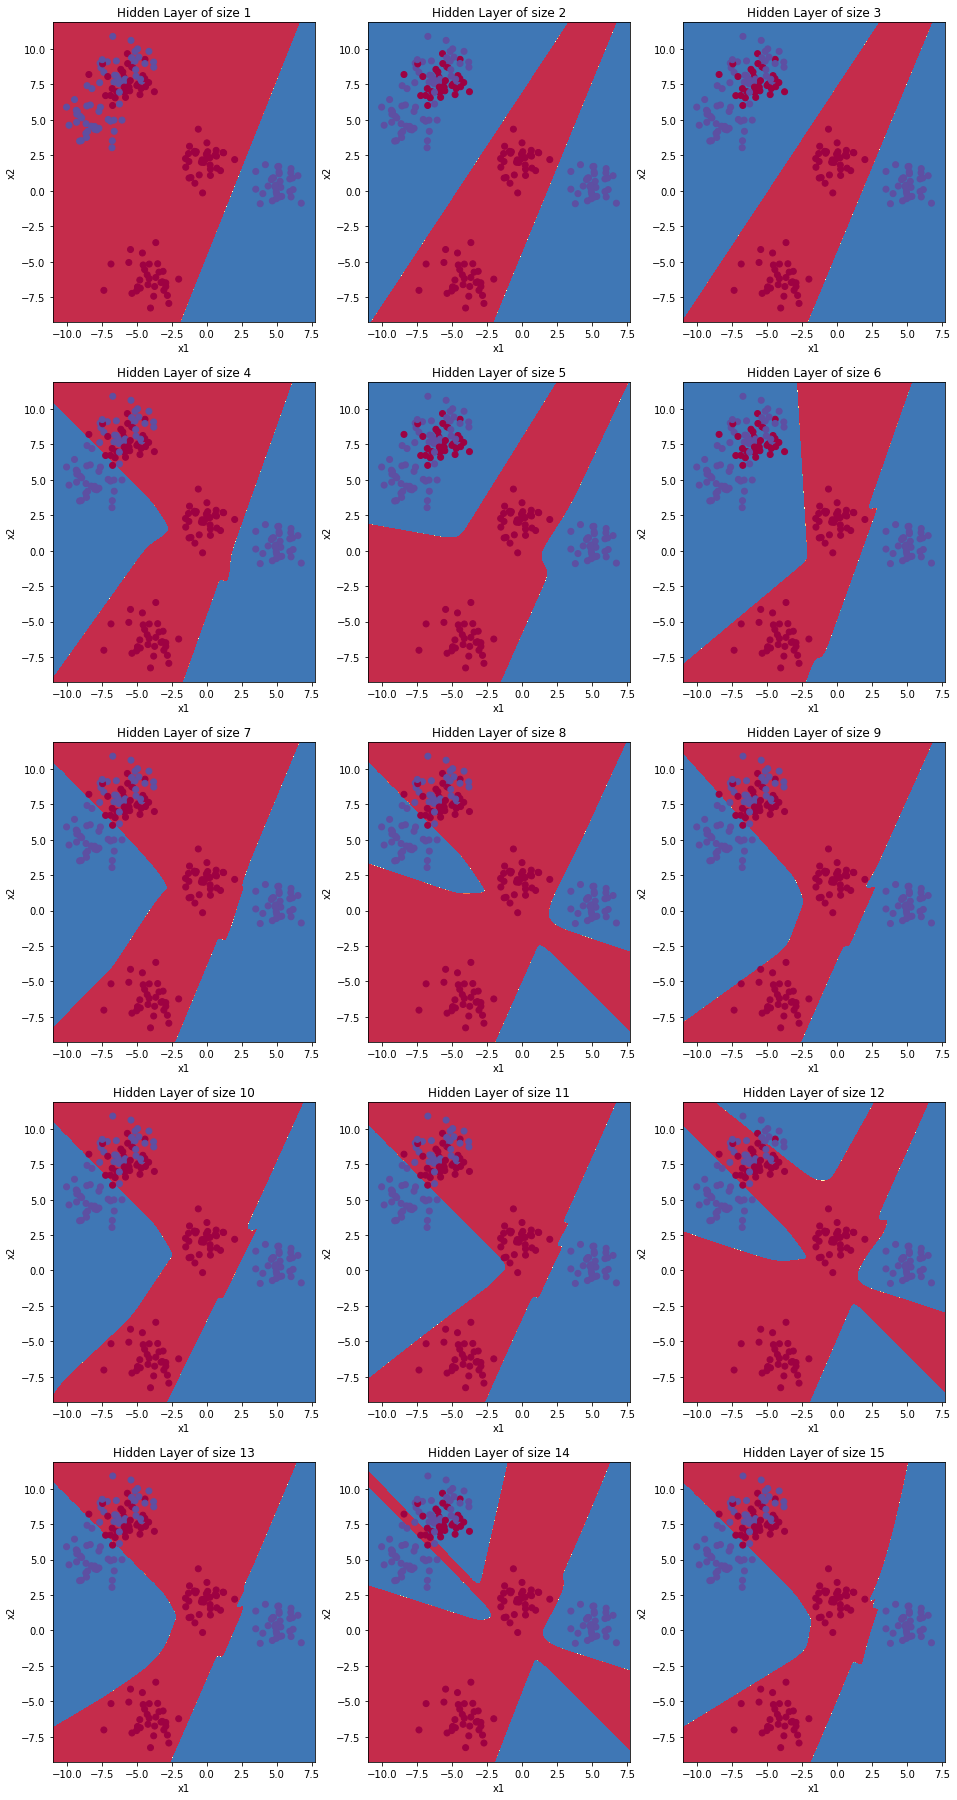

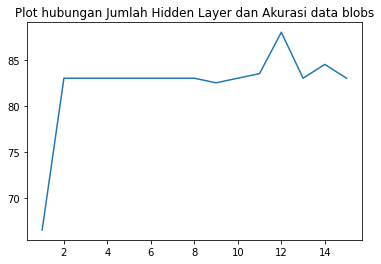

In [49]:
# Bentuk yang diinginkan
shape = "blobs"
# Ambil dataset
X, Y = loader.load_dataset(shape)
# Membuat plot baru
plt.figure(figsize=(16, 32))
# Membuat list banyak neuron pada hidden layer yang akan digunakan [1, 2, ..., 15]
hidden_layer_sizes = np.arange(1, 16, 1)
# Akurasi dari tiap hidden layer
accuracy = []
# Looping tiap banyak neuron
for i, n_h in enumerate(hidden_layer_sizes):
    # Plot
    plt.subplot(5, 3, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    # Model
    parameters = nn_model(X, Y, n_h, num_iterations = 10000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    acc = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, acc))
    accuracy.append(acc)
plt.show()

# Plot grafik banyak neuron hidden layer serta akurasi-nya
plt.title('Plot hubungan Jumlah Hidden Layer dan Akurasi data ' +shape)
plt.plot(hidden_layer_sizes, accuracy)
plt.show()

Perhatikan bahwa kita dapat memisahkan titik-titik berwarna biru menjadi 2 daerah biru terpisah. Sehingga, jika 1 neuron dapat membagi 1 daerah, maka cukup digunakan 2 buah neuron untuk memodelkan *decision boundary* pada dataset tersebut.

Hal ini dapat diverifikasi lebih lanjut dengan melihat plot akurasinya. Terlihat bahwa pada saat banyak neuron dari 1 ke 2 buah terdapat lompatan akurasi yang sangat besar. Lebih lanjut, akurasi untuk banyak neuron lebih dari 2 tidak bertambah secara signifikan ($10-12$ terdapat anomali yang mungkin disebabkan oleh sifat random dari program neural network).

Sehingga, cukup dibutuhkan 2 neuron untuk dapat membagi daerah dengan baik.

#### 2.5 - Quantiles

Berikut adalah hasil training menggunakan data 'quantiles'

Accuracy for 1 hidden units: 66.5 %
Accuracy for 2 hidden units: 80.5 %
Accuracy for 3 hidden units: 95.0 %


C:\Users\Acer\AppData\Local\Temp/ipykernel_8508/3071538602.py:5: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(np.log(A2), Y) + np.multiply(np.log(1-A2), 1-Y)
C:\Users\Acer\AppData\Local\Temp/ipykernel_8508/3071538602.py:5: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(np.log(A2), Y) + np.multiply(np.log(1-A2), 1-Y)


Accuracy for 4 hidden units: 98.0 %
Accuracy for 5 hidden units: 100.0 %
Accuracy for 6 hidden units: 100.0 %
Accuracy for 7 hidden units: 100.0 %
Accuracy for 8 hidden units: 100.0 %
Accuracy for 9 hidden units: 100.0 %
Accuracy for 10 hidden units: 100.0 %
Accuracy for 11 hidden units: 100.0 %
Accuracy for 12 hidden units: 100.0 %
Accuracy for 13 hidden units: 100.0 %
Accuracy for 14 hidden units: 100.0 %
Accuracy for 15 hidden units: 100.0 %


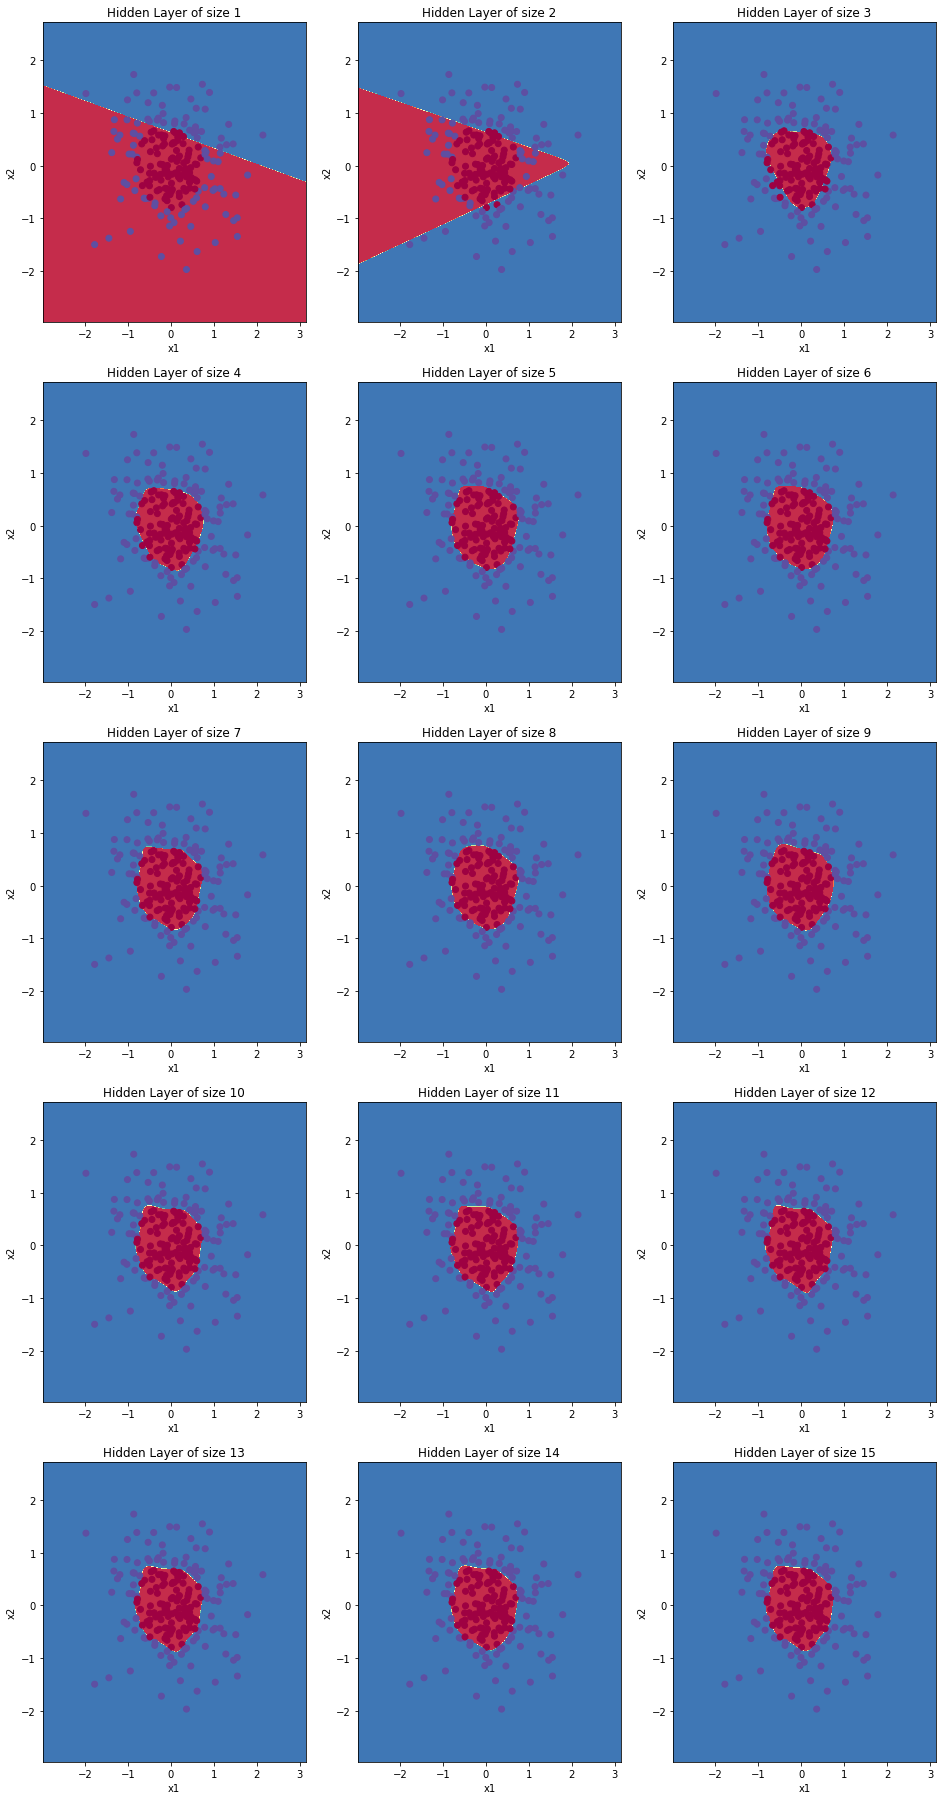

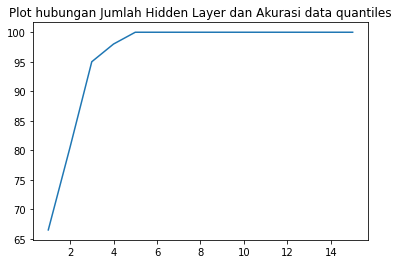

In [50]:
# Bentuk yang diinginkan
shape = "quantiles"
# Ambil dataset
X, Y = loader.load_dataset(shape)
# Membuat plot baru
plt.figure(figsize=(16, 32))
# Membuat list banyak neuron pada hidden layer yang akan digunakan [1, 2, ..., 15]
hidden_layer_sizes = np.arange(1, 16, 1)
# Akurasi dari tiap hidden layer
accuracy = []
# Looping tiap banyak neuron
for i, n_h in enumerate(hidden_layer_sizes):
    # Plot
    plt.subplot(5, 3, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    # Model
    parameters = nn_model(X, Y, n_h, num_iterations = 10000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    acc = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, acc))
    accuracy.append(acc)
plt.show()

# Plot grafik banyak neuron hidden layer serta akurasi-nya
plt.title('Plot hubungan Jumlah Hidden Layer dan Akurasi data ' +shape)
plt.plot(hidden_layer_sizes, accuracy)
plt.show()

Perhatikan bahwa untuk kasus dataset 'quantiles' memiliki karakteristik data yang serupa dengan 'circles'. Sehingga penjelasan pada dataset 'circles' berlaku di dataset 'quantiles', yakni untuk membagi daerah menjadi 2 daerah berbentuk bulat dan sisanya, dibutuhkan minimal 3 garis (membentuk segitiga, bentuk geometri tertutup paling sederhana). Sehingga jika 1 neuron menghasilkan 1 garis, maka dibutuhkan 3 neuron saja untuk mendapat *decision boundary* pada data set ini.

Hal ini dapat diverifikasi dari plot akurasi, yakni peningkatan pesat akurasi dari banyak neuron antara $1-3$ dan peningkatan yang lambat pada saat banyak neuron lebih dari $3$.

Maka, cukup digunakan 3 buah neuron untuk mendapat *decision boundary* pada data set ini.

#### 2.6 - Random

Berikut adalah hasil training menggunakan data 'random'

Accuracy for 1 hidden units: 53.0 %
Accuracy for 2 hidden units: 56.00000000000001 %
Accuracy for 3 hidden units: 63.5 %
Accuracy for 4 hidden units: 62.5 %
Accuracy for 5 hidden units: 63.0 %
Accuracy for 6 hidden units: 61.5 %
Accuracy for 7 hidden units: 64.0 %
Accuracy for 8 hidden units: 65.0 %
Accuracy for 9 hidden units: 64.5 %
Accuracy for 10 hidden units: 62.5 %
Accuracy for 11 hidden units: 66.0 %
Accuracy for 12 hidden units: 64.5 %
Accuracy for 13 hidden units: 64.5 %
Accuracy for 14 hidden units: 63.0 %
Accuracy for 15 hidden units: 63.5 %


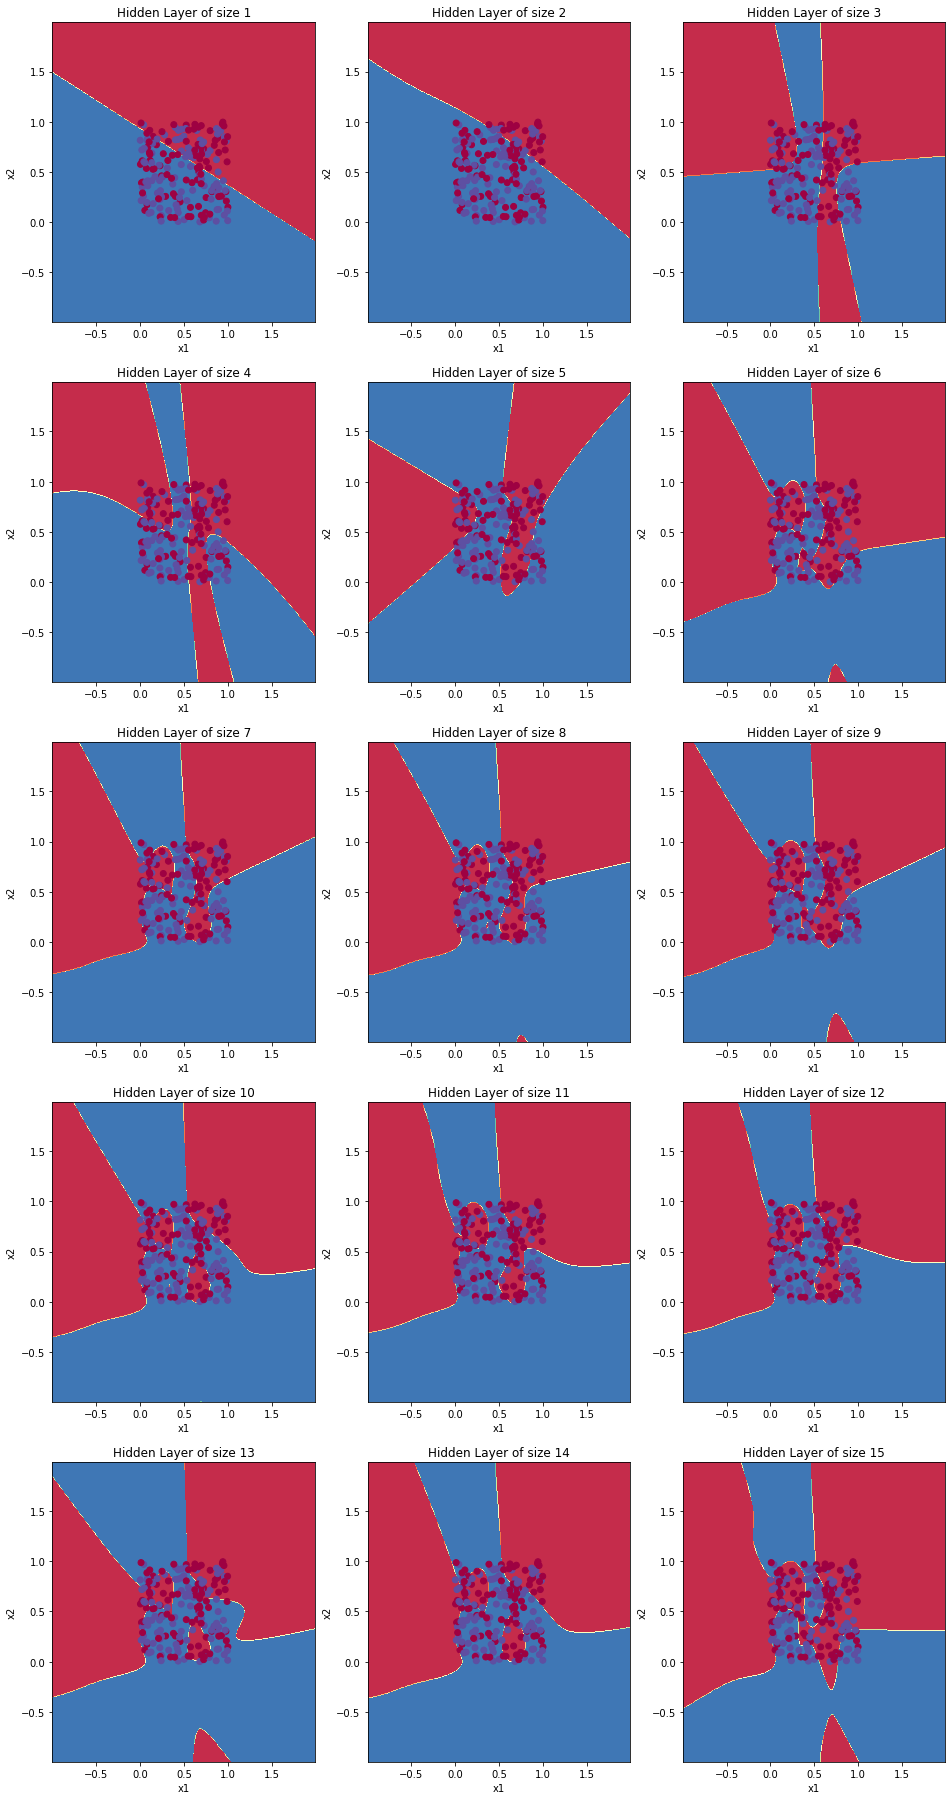

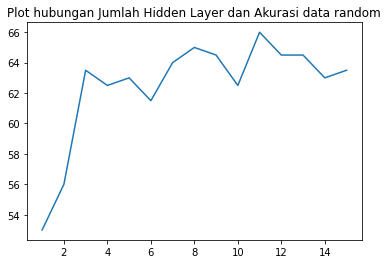

In [52]:
# Bentuk yang diinginkan
shape = "random"
# Ambil dataset
X, Y = loader.load_dataset(shape)
# Membuat plot baru
plt.figure(figsize=(16, 32))
# Membuat list banyak neuron pada hidden layer yang akan digunakan [1, 2, ..., 15]
hidden_layer_sizes = np.arange(1, 16, 1)
# Akurasi dari tiap hidden layer
accuracy = []
# Looping tiap banyak neuron
for i, n_h in enumerate(hidden_layer_sizes):
    # Plot
    plt.subplot(5, 3, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    # Model
    parameters = nn_model(X, Y, n_h, num_iterations = 10000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    acc = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, acc))
    accuracy.append(acc)
plt.show()

# Plot grafik banyak neuron hidden layer serta akurasi-nya
plt.title('Plot hubungan Jumlah Hidden Layer dan Akurasi data ' +shape)
plt.plot(hidden_layer_sizes, accuracy)
plt.show()

Secara umum, semakin banyak <i>neuron</i> yang digunakan, maka akurasi akan meningkat. Namun karena sifat keacakan, beberapa <i>neuron</i> menunjukkan hasil yang jauh lebih baik dibandingkan banyak <i>neuron</i> yang lain.

#### 2.7 - Kesimpulan

Dari dataset yang beragam, dapat disimpulkan bahwa banyak neuron minimum yang optimal dapat diperkirakan dengan menganalisis bentuk dataset yang dihasilkan. Jika data yang dimasukkan adalah posisi X dan Y, serta daerah dibagi menjadi 2 warna/jenis, maka 1 neuron akan menghasilkan 1 garis "lurus" (sebenarnya belum tentu lurus karena fungsi aktivasi tanh dan sigmoid yang digunakan bukan merupakan fungsi linear). Dengan cara tersebut, maka neuron minimal bisa didapat dengan hasil yang cukup memuaskan.